In [56]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib.patches import Circle, Rectangle, Arc
import seaborn as sns

from sklearn.metrics import accuracy_score, log_loss
import xgboost as xgb
from sklearn.model_selection import GroupKFold

plt.style.use("fivethirtyeight")
mypal = plt.rcParams["axes.prop_cycle"].by_key()["color"]

In [57]:
!ls -GFlash ../input/march-machine-learning-mania-2024/

total 144M
   0 drwxr-xr-x 2 nobody    0 May 13 13:50 ./
4.0K drwxr-xr-x 3 root   4.0K Jun  9 16:15 ../
4.0K -rw-r--r-- 1 nobody 1.4K May 13 13:50 2024_tourney_seeds.csv
 12K -rw-r--r-- 1 nobody 9.1K May 13 13:50 Cities.csv
4.0K -rw-r--r-- 1 nobody 1.7K May 13 13:50 Conferences.csv
168K -rw-r--r-- 1 nobody 168K May 13 13:50 MConferenceTourneyGames.csv
2.5M -rw-r--r-- 1 nobody 2.5M May 13 13:50 MGameCities.csv
111M -rw-r--r-- 1 nobody 111M May 13 13:50 MMasseyOrdinals_thruSeason2024_day128.csv
 72K -rw-r--r-- 1 nobody  72K May 13 13:50 MNCAATourneyCompactResults.csv
132K -rw-r--r-- 1 nobody 129K May 13 13:50 MNCAATourneyDetailedResults.csv
 16K -rw-r--r-- 1 nobody  16K May 13 13:50 MNCAATourneySeedRoundSlots.csv
 40K -rw-r--r-- 1 nobody  38K May 13 13:50 MNCAATourneySeeds.csv
 52K -rw-r--r-- 1 nobody  50K May 13 13:50 MNCAATourneySlots.csv
5.3M -rw-r--r-- 1 nobody 5.3M May 13 13:50 MRegularSeasonCompactResults.csv
 11M -rw-r--r-- 1 nobody  11M May 13 13:50 MRegularSeasonDetailedResults.

# **Files we are interested in:**

* ***MRegularSeasonCompactResults.csv & WMRegularSeasonCompactResults.csv**

    All game results from the regular season.
* **MNCAATourneyCompactResults.csv & WNCAATourneyCompactResults.csv**

    All game results from past tournaments.
* **MNCAATourneySeeds.csv & MNCAATourneySeeds.csv**

     The seeding for the tournaments
* *** 2024_tourney_seeds.csv**

   File that will be updated with 2024 seeds once released (2023 seeds prior to that)

In [58]:
DATA_PATH = "../input/march-machine-learning-mania-2024/"

In [59]:
df_seeds = pd.concat(
    [
        pd.read_csv(DATA_PATH + "MNCAATourneySeeds.csv").assign(League="M"),
        pd.read_csv(DATA_PATH + "WNCAATourneySeeds.csv").assign(League="W"),
    ],
).reset_index(drop=True)

df_season_results = pd.concat(
    [
        pd.read_csv(DATA_PATH + "MRegularSeasonCompactResults.csv").assign(League="M"),
        pd.read_csv(DATA_PATH + "WRegularSeasonCompactResults.csv").assign(League="W"),
    ]
).reset_index(drop=True)

df_tourney_results = pd.concat(
    [
        pd.read_csv(DATA_PATH + "MNCAATourneyCompactResults.csv").assign(League="M"),
        pd.read_csv(DATA_PATH + "WNCAATourneyCompactResults.csv").assign(League="W"),
    ]
).reset_index(drop=True)

# **Creating Team Season Results**

* We the the data from the existing format with 1 row per game
* New format has 1 row for each team's game - win or loss.
* This data can be aggregated for season metrics

In [60]:
df_team_season_results = pd.concat(
    [
        df_season_results[["Season", "League", "WTeamID", "DayNum", "WScore", "LScore"]]
        .assign(GameResult="W")
        .rename(
            columns={"WTeamID": "TeamID", "WScore": "TeamScore", "LScore": "OppScore"}
        ),
        df_season_results[["Season", "League", "LTeamID", "DayNum", "WScore", "LScore"]]
        .assign(GameResult="L")
        .rename(
            columns={"LTeamID": "TeamID", "LScore": "TeamScore", "WScore": "OppScore"}
        ),
    ]
).reset_index(drop=True)

# Create Season Features

* add some features to this data like the score differential

In [61]:
# Score Differential
df_team_season_results["ScoreDiff"] = (
    df_team_season_results["TeamScore"] - df_team_season_results["OppScore"]
)
df_team_season_results["Win"] = (df_team_season_results["GameResult"] == "W").astype(
    "int"
)

In [62]:
df_team_season_results.sample(10, random_state=529)

,Season,League,TeamID,DayNum,TeamScore,OppScore,GameResult,ScoreDiff,Win
493232,2022,M,1444,96,64,77,L,-13,0
71811,2002,M,1281,79,74,50,W,24,1
555548,2008,W,3276,115,67,69,L,-2,0
84226,2005,M,1393,40,86,56,W,30,1
129439,2014,M,1368,8,63,62,W,1,1
364900,1996,M,1148,85,46,116,L,-70,0
587485,2015,W,3394,18,66,68,L,-2,0
397470,2003,M,1266,129,76,83,L,-7,0
99374,2008,M,1177,47,93,88,W,5,1
532105,2003,W,3414,130,50,83,L,-33,0


# Aggregate for team's total season stats



In [63]:
# Aggregate the data
team_season_agg = (
    df_team_season_results.groupby(["Season", "TeamID", "League"])
    .agg(
        AvgScoreDiff=("ScoreDiff", "mean"),
        MedianScoreDiff=("ScoreDiff", "median"),
        MinScoreDiff=("ScoreDiff", "min"),
        MaxScoreDiff=("ScoreDiff", "max"),
        Wins=("Win", "sum"),
        Losses=("GameResult", lambda x: (x == "L").sum()),
        WinPercentage=("Win", "mean"),
    )
    .reset_index()
)

In [64]:
team_season_agg.head()

,Season,TeamID,League,AvgScoreDiff,MedianScoreDiff,MinScoreDiff,MaxScoreDiff,Wins,Losses,WinPercentage
0,1985,1102,M,-5.791667,-5.5,-41,29,5,19,0.208333
1,1985,1103,M,-3.043478,-2.0,-22,16,9,14,0.391304
2,1985,1104,M,7.800000,6.5,-12,25,21,9,0.700000
3,1985,1106,M,-3.791667,-1.5,-35,28,10,14,0.416667
4,1985,1108,M,7.960000,4.0,-15,35,19,6,0.760000


In [65]:
df_seeds["ChalkSeed"] = (
    df_seeds["Seed"].str.replace("a", "").str.replace("b", "").str[1:].astype("int")
)

team_season_agg = team_season_agg.merge(
    df_seeds, on=["Season", "TeamID", "League"], how="left"
)

In [66]:
team_season_agg.shape, df_seeds.shape

((22150, 12), (4234, 5))

# Tournament Results Aggregation

In [67]:
df_team_tourney_results = pd.concat(
    [
        df_tourney_results[
            ["Season", "League", "WTeamID", "LTeamID", "WScore", "LScore"]
        ]
        .assign(GameResult="W")
        .rename(
            columns={
                "WTeamID": "TeamID",
                "LTeamID": "OppTeamID",
                "WScore": "TeamScore",
                "LScore": "OppScore",
            }
        ),
        df_tourney_results[
            ["Season", "League", "LTeamID", "WTeamID", "LScore", "WScore"]
        ]
        .assign(GameResult="L")
        .rename(
            columns={
                "LTeamID": "TeamID",
                "WTeamID": "OppTeamID",
                "LScore": "TeamScore",
                "WScore": "OppScore",
            }
        ),
    ]
).reset_index(drop=True)

df_team_tourney_results["Win"] = (df_team_tourney_results["GameResult"] == "W").astype(
    "int"
)

In [68]:
df_team_tourney_results.head()

,Season,League,TeamID,OppTeamID,TeamScore,OppScore,GameResult,Win
0,1985,M,1116,1234,63,54,W,1
1,1985,M,1120,1345,59,58,W,1
2,1985,M,1207,1250,68,43,W,1
3,1985,M,1229,1425,58,55,W,1
4,1985,M,1242,1325,49,38,W,1


# Tourney Dataset with Features

* merge our team's regular season features with our tourney dataframe.
* This gives us the data format that we will use to train our model.
* target column is the "Winner" and the features are the regular season stats.

In [69]:
df_historic_tourney_features = df_team_tourney_results.merge(
    team_season_agg[
        ["Season", "League", "TeamID", "WinPercentage", "MedianScoreDiff", "ChalkSeed"]
    ],
    on=["Season", "League", "TeamID"],
    how="left",
).merge(
    team_season_agg[
        ["Season", "League", "TeamID", "WinPercentage", "MedianScoreDiff", "ChalkSeed"]
    ].rename(
        columns={
            "TeamID": "OppTeamID",
            "WinPercentage": "OppWinPercentage",
            "MedianScoreDiff": "OppMedianScoreDiff",
            "ChalkSeed": "OppChalkSeed",
        }
    ),
    on=["Season", "League", "OppTeamID"],
)

In [70]:
df_historic_tourney_features.head()

,Season,League,TeamID,OppTeamID,TeamScore,OppScore,GameResult,Win,WinPercentage,MedianScoreDiff,ChalkSeed,OppWinPercentage,OppMedianScoreDiff,OppChalkSeed
0,1985,M,1116,1234,63,54,W,1,0.636364,5.0,9.0,0.666667,9.5,8.0
1,1985,M,1120,1345,59,58,W,1,0.620690,2.0,11.0,0.680000,9.0,6.0
2,1985,M,1207,1250,68,43,W,1,0.925926,14.0,1.0,0.379310,-3.0,16.0
3,1985,M,1229,1425,58,55,W,1,0.740741,6.0,9.0,0.678571,2.5,8.0
4,1985,M,1242,1325,49,38,W,1,0.766667,5.5,3.0,0.740741,6.0,14.0


In [71]:
 df_historic_tourney_features.columns

Index(['Season', 'League', 'TeamID', 'OppTeamID', 'TeamScore', 'OppScore',
       'GameResult', 'Win', 'WinPercentage', 'MedianScoreDiff', 'ChalkSeed',
       'OppWinPercentage', 'OppMedianScoreDiff', 'OppChalkSeed'],
      dtype='object')

In [72]:
df_historic_tourney_features["WinPctDiff"] = (
    df_historic_tourney_features["WinPercentage"]
    - df_historic_tourney_features["OppWinPercentage"]
)

df_historic_tourney_features["ChalkSeedDiff"] = (
    df_historic_tourney_features["ChalkSeed"]
    - df_historic_tourney_features["OppChalkSeed"]
)

df_historic_tourney_features["MedianScoreDiffDiff"] = (
    df_historic_tourney_features["MedianScoreDiff"]
    - df_historic_tourney_features["OppMedianScoreDiff"]
)

In [73]:
df_historic_tourney_features

,Season,League,TeamID,OppTeamID,TeamScore,OppScore,GameResult,Win,WinPercentage,MedianScoreDiff,ChalkSeed,OppWinPercentage,OppMedianScoreDiff,OppChalkSeed,WinPctDiff,ChalkSeedDiff,MedianScoreDiffDiff
0,1985,M,1116,1234,63,54,W,1,0.636364,5.0,9.0,0.666667,9.5,8.0,-0.030303,1.0,-4.5
1,1985,M,1120,1345,59,58,W,1,0.620690,2.0,11.0,0.680000,9.0,6.0,-0.059310,5.0,-7.0
2,1985,M,1207,1250,68,43,W,1,0.925926,14.0,1.0,0.379310,-3.0,16.0,0.546616,-15.0,17.0
3,1985,M,1229,1425,58,55,W,1,0.740741,6.0,9.0,0.678571,2.5,8.0,0.062169,1.0,3.5
4,1985,M,1242,1325,49,38,W,1,0.766667,5.5,3.0,0.740741,6.0,14.0,0.025926,-11.0,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8063,2023,W,3268,3376,75,86,L,0,0.806452,11.0,2.0,1.000000,28.0,1.0,-0.193548,1.0,-17.0
8064,2023,W,3326,3439,74,84,L,0,0.781250,12.0,3.0,0.870968,13.0,1.0,-0.089718,2.0,-1.0
8065,2023,W,3376,3234,73,77,L,0,1.000000,28.0,1.0,0.812500,13.5,2.0,0.187500,-1.0,14.5
8066,2023,W,3439,3261,72,79,L,0,0.870968,13.0,1.0,0.933333,22.0,3.0,-0.062366,-2.0,-9.0


In [74]:
TeamID = 1116
filtered_wins =  df_historic_tourney_features[ df_historic_tourney_features['TeamID'] == TeamID]
filtered_wins

,Season,League,TeamID,OppTeamID,TeamScore,OppScore,GameResult,Win,WinPercentage,MedianScoreDiff,ChalkSeed,OppWinPercentage,OppMedianScoreDiff,OppChalkSeed,WinPctDiff,ChalkSeedDiff,MedianScoreDiffDiff
0,1985,M,1116,1234,63,54,W,1,0.636364,5.0,9.0,0.666667,9.5,8.0,-0.030303,1.0,-4.5
253,1989,M,1116,1258,120,101,W,1,0.800000,16.5,5.0,0.655172,5.0,12.0,0.144828,-7.0,11.5
315,1990,M,1116,1343,68,64,W,1,0.866667,15.0,4.0,0.750000,11.5,13.0,0.116667,-9.0,3.5
347,1990,M,1116,1173,86,84,W,1,0.866667,15.0,4.0,0.700000,6.0,12.0,0.166667,-8.0,9.0
363,1990,M,1116,1314,96,73,W,1,0.866667,15.0,4.0,0.612903,5.0,8.0,0.253763,-4.0,10.0
371,1990,M,1116,1400,88,85,W,1,0.866667,15.0,4.0,0.700000,6.0,10.0,0.166667,-6.0,9.0
396,1991,M,1116,1209,117,76,W,1,0.909091,20.0,1.0,0.533333,1.0,16.0,0.375758,-15.0,19.0
419,1991,M,1116,1113,97,90,W,1,0.909091,20.0,1.0,0.678571,6.0,8.0,0.230519,-7.0,14.0
426,1991,M,1116,1104,93,70,W,1,0.909091,20.0,1.0,0.700000,5.5,4.0,0.209091,-3.0,14.5
442,1992,M,1116,1293,80,69,W,1,0.758621,11.0,3.0,0.571429,3.0,14.0,0.187192,-11.0,8.0


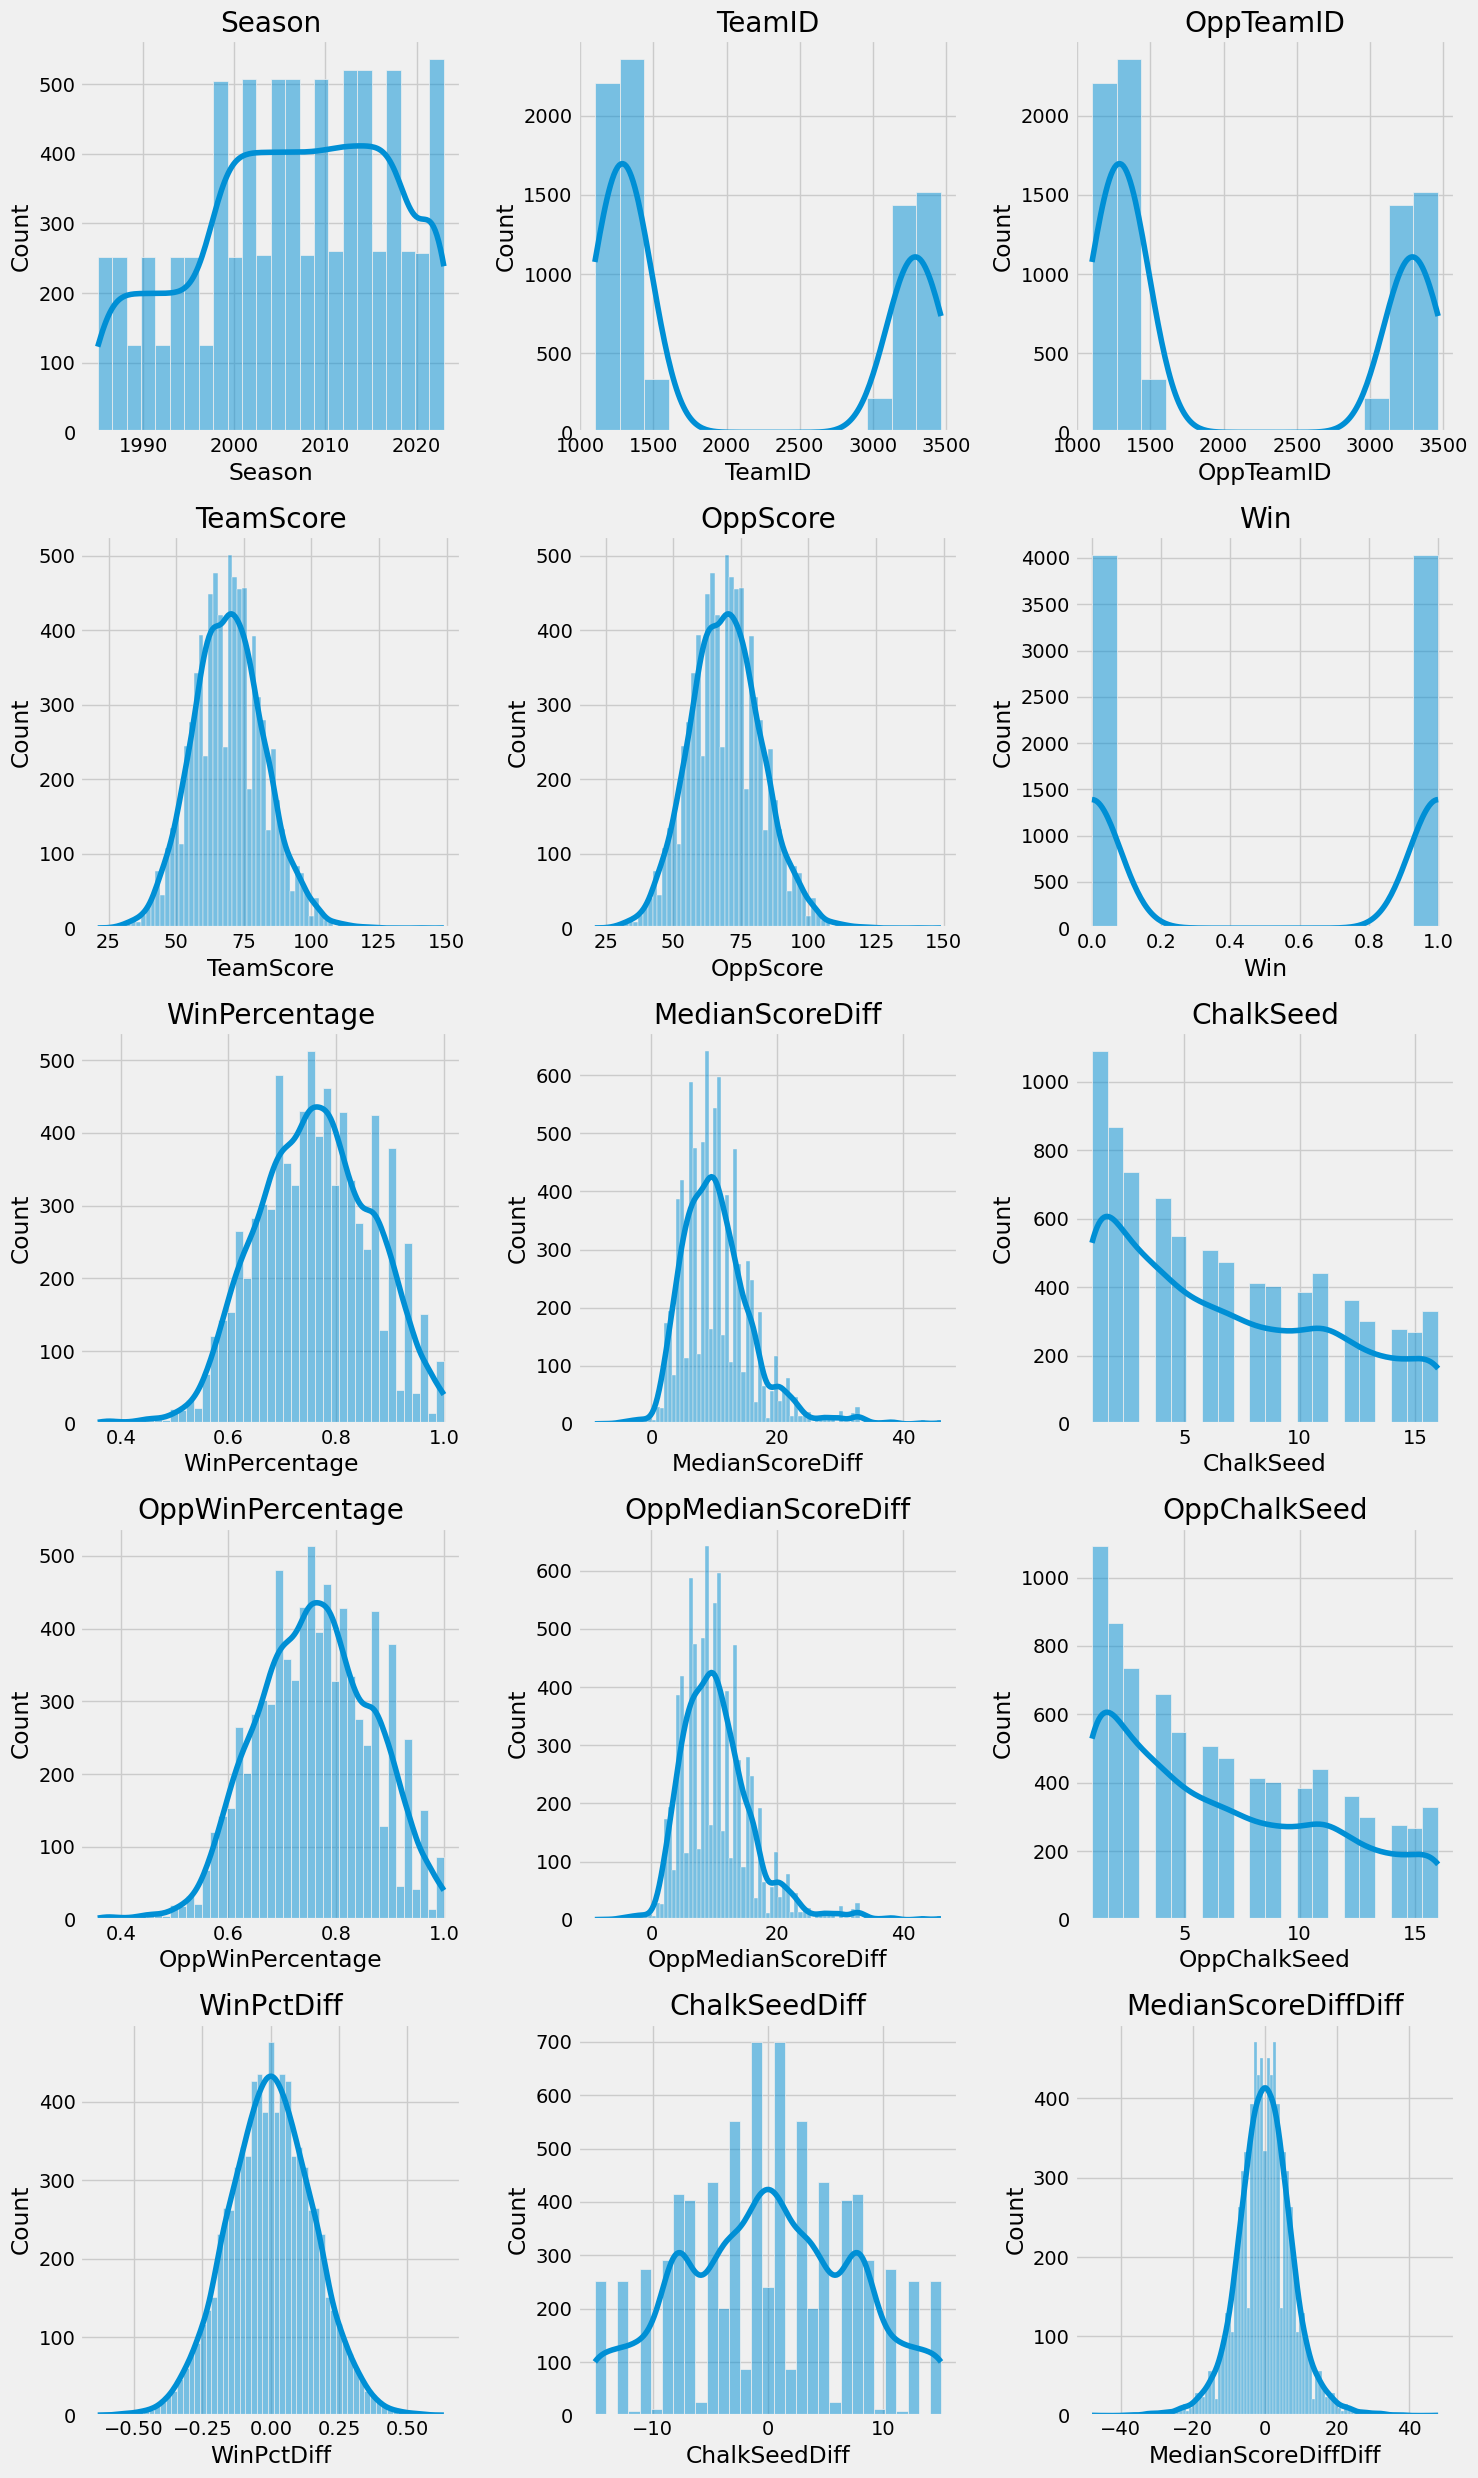

In [75]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Suppress all warnings
warnings.filterwarnings('ignore')

# Replace infinite values with NaN
df_historic_tourney_features.replace([np.inf, -np.inf], np.nan, inplace=True)


# Get numerical features
numerical_features = df_historic_tourney_features.select_dtypes(include=['float64', 'int64']).columns

# Calculate the number of rows and columns for subplots
num_features = len(numerical_features)
num_cols = 3
num_rows = math.ceil(num_features / num_cols)

plt.figure(figsize=(15, num_rows * 5))
for i, col in enumerate(numerical_features):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(df_historic_tourney_features[col], kde=True)
    plt.title(col)

plt.tight_layout()
plt.show()

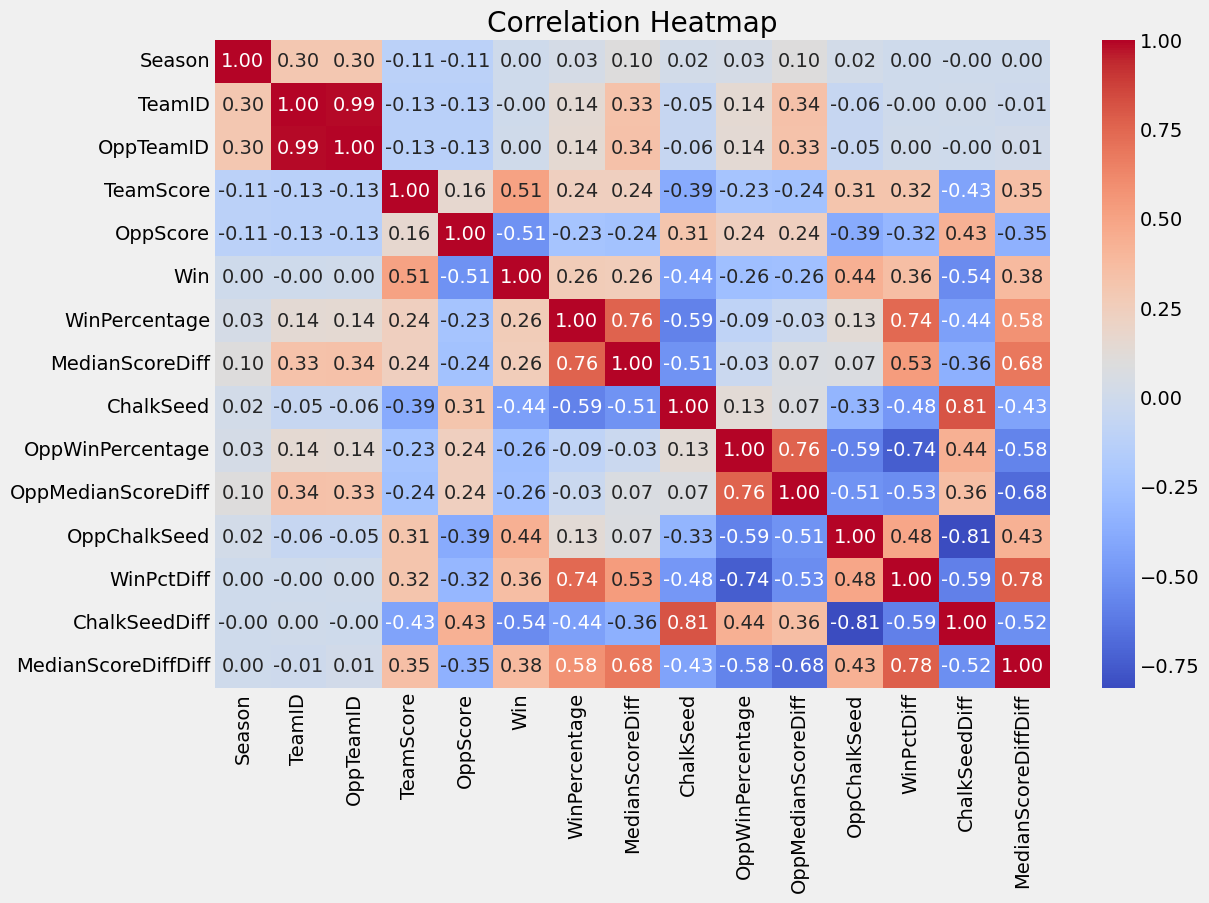

In [76]:
# Plot correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = df_historic_tourney_features[numerical_features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Baseline - Higher Seed Wins

To do this we will simply score the accuracy on historic tournaments assuming the higher seed always wins.

In [77]:
df_historic_tourney_features["BaselinePred"] = (
    df_historic_tourney_features["ChalkSeed"]
    < df_historic_tourney_features["OppChalkSeed"]
)

df_historic_tourney_features.loc[
    df_historic_tourney_features["ChalkSeed"]
    == df_historic_tourney_features["OppChalkSeed"],
    "BaselinePred",
] = (
    df_historic_tourney_features["WinPercentage"]
    > df_historic_tourney_features["OppWinPercentage"]
)

In [78]:
from sklearn.metrics import accuracy_score, log_loss

cv_scores_baseline = []
for season in df_historic_tourney_features["Season"].unique():
    pred = df_historic_tourney_features.query("Season == @season")[
        "BaselinePred"
    ].astype("int")
    y = df_historic_tourney_features.query("Season == @season")["Win"]
    score = accuracy_score(y, pred)
    score_ll = log_loss(y, pred)
    cv_scores_baseline.append(score)
    print(f"Holdout season {season} - Accuracy {score:0.4f} Log Loss {score_ll:0.4f}")

print(f"Baseline accuracy {np.mean(cv_scores_baseline):0.4f}")

Holdout season 1985 - Accuracy 0.7143 Log Loss 10.2982
Holdout season 1986 - Accuracy 0.7143 Log Loss 10.2982
Holdout season 1987 - Accuracy 0.6984 Log Loss 10.8703
Holdout season 1988 - Accuracy 0.7143 Log Loss 10.2982
Holdout season 1989 - Accuracy 0.6667 Log Loss 12.0146
Holdout season 1990 - Accuracy 0.6825 Log Loss 11.4424
Holdout season 1991 - Accuracy 0.7460 Log Loss 9.1539
Holdout season 1992 - Accuracy 0.7619 Log Loss 8.5818
Holdout season 1993 - Accuracy 0.7937 Log Loss 7.4376
Holdout season 1994 - Accuracy 0.7143 Log Loss 10.2982
Holdout season 1995 - Accuracy 0.7619 Log Loss 8.5818
Holdout season 1996 - Accuracy 0.7460 Log Loss 9.1539
Holdout season 1997 - Accuracy 0.7302 Log Loss 9.7261
Holdout season 1998 - Accuracy 0.7143 Log Loss 10.2982
Holdout season 1999 - Accuracy 0.7222 Log Loss 10.0121
Holdout season 2000 - Accuracy 0.7302 Log Loss 9.7261
Holdout season 2001 - Accuracy 0.7047 Log Loss 10.6428
Holdout season 2002 - Accuracy 0.7480 Log Loss 9.0819
Holdout season 200

# XGBoost Model